# CIFAR10 AutoEncoder Milestone Project

1) Import the data, create train/dev/test DataLoaders
2) Make sure the data are 3x32x32
3) Create an AutoEncoder model for CIFAR10, with channels:

(3x32x32)

(16x16x16) -> k=4, p=1, s=2

(32x8x8)   -> k=4, p=1, s=2

(64x4x4)   -> k=4, p=1, s=2

(32x8x8)   -> k=4, p=1, s=2

(16x16x16) -> k=4, p=1, s=2

(3x32x32)          

## Import Modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

import torchvision
import torchvision.transforms as T

from sklearn.model_selection import train_test_split

## GPU usage

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Prepare CustomDataset class for transformations

In [3]:
# # define CustomDataset class
# class CustomDataset(Dataset):
#     # take TensorDataset definition and adjust it to your needs
#     def __init__(self, tensors, transform = None) -> None:
#         assert tensors[0].size(0) == tensors[1].size(0), "Size mismatch between data and labels"
#         self.tensors = tensors
#         self.transform = transform

#     def __getitem__(self, index): # dataloader calls singular items from batches with this index.
#                                   # So we need to return a single item and apply the transformation on it
#         y = self.tensors[1][index]
#         if self.transform is not None:
#             x = self.transform(self.tensors[0][index])
#         else:
#             x = self.tensors[0][index]
#         return x,y

#     def __len__(self):
#         return self.tensors[0].size(0)

## Import Dataset 

In [4]:
# transform
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

trainset = torchvision.datasets.CIFAR10(root="../../datasets/CIFAR10", train=True,  download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root="../../datasets/CIFAR10", train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=32, drop_last=True, shuffle=True)
test_loader  = DataLoader(testset,  batch_size=256)

100%|██████████| 170498071/170498071 [00:11<00:00, 14234464.33it/s]


Extracting ../../datasets/CIFAR10\cifar-10-python.tar.gz to ../../datasets/CIFAR10
Files already downloaded and verified


## Prepare training, development and test sets

In [5]:
X, y = next(iter(train_loader))
X.shape

torch.Size([32, 3, 32, 32])

## Create DL class

In [6]:
class CIFAR_AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            # Conv layer 1
            nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # output size = ((32 + 2*1 - 4)/2 + 1) = 16
            
            # Conv layer 2
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # output size = ((16 + 2*1 - 4)/2 + 1) = 8

            # Conv layer 3
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # output size = ((8 + 2*1 - 4)/2 + 1) = 4
        )

        self.dec = nn.Sequential(

            # convtranspose 1
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # output size = 2*(4 - 1) - 2*1 + 4 = 8

            # convtranspose 2
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # output size = 2*(8 - 1) - 2*1 + 4 = 16

            # convtranspose 3
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # output size = 2*(16 - 1) - 2*1 + 4 = 32
        )

    def forward(self, x):
        return self.dec(self.enc(x))

In [7]:
# test the class
model = CIFAR_AE()
model

CIFAR_AE(
  (enc): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (dec): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
)

## Define model creation function

In [15]:
def create_model():
    # create model
    net = CIFAR_AE()
    lossfun = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.005, weight_decay=0.001)

    return net, lossfun, optimizer

In [16]:
# test if function works properly
print(create_model())

(CIFAR_AE(
  (enc): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (dec): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
), MSELoss(), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0.001
))


## Define model training function

In [21]:
num_epochs = 20

def train_model():
    # create model, lossfun, optimizer
    model, lossfun, optimizer = create_model()
    model = model.to(device)

    # keep losses
    train_losses = []
    test_losses  = []

    # start training
    for i in range(num_epochs):

        print(f"Epoch {i+1}/{num_epochs}")

        # put model in training mode
        model.train()

        # batch losses
        batch_loss = []

        for batch, label in train_loader:

            batch = batch.to(device)
            # push the batch
            yHat_train = model(batch)
            batch = batch.cpu()
            yHat_train = yHat_train.cpu()
            loss = lossfun(yHat_train, batch)
            batch_loss.append(loss.item())
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # end of batches
        model.eval()

        # store average training accuracy and losses
        train_losses.append(np.mean(batch_loss))

        # get evaluations from the dev set
        X_test, y_test = next(iter(test_loader))
        X_test_device = X_test.to(device)
        yHat_test_device = model(X_test_device)
        yHat_test = yHat_test_device.cpu()
        
        # store dev loss
        test_loss = lossfun(yHat_test, X_test)
        test_losses.append(test_loss.item())
        print(f"Dev loss:{test_loss.item()}")
        # print(f"Training done in {time.process_time() - start_time} seconds") if i%100 == 0 else None
    # end of training

    # return the model and statistics
    return train_losses, test_losses, model

In [22]:
# final step
num_epochs = 20
train_losses, test_losses, model = train_model()

Epoch 1/20
Dev loss:0.15758566558361053
Epoch 2/20
Dev loss:0.1537136733531952
Epoch 3/20
Dev loss:0.15361644327640533
Epoch 4/20
Dev loss:0.15386606752872467
Epoch 5/20
Dev loss:0.16568517684936523
Epoch 6/20
Dev loss:0.15377354621887207
Epoch 7/20
Dev loss:0.15406863391399384
Epoch 8/20
Dev loss:0.15620426833629608
Epoch 9/20
Dev loss:0.15375995635986328
Epoch 10/20
Dev loss:0.15503409504890442
Epoch 11/20
Dev loss:0.1541755050420761
Epoch 12/20
Dev loss:0.15383195877075195
Epoch 13/20
Dev loss:0.15478737652301788
Epoch 14/20
Dev loss:0.15374010801315308
Epoch 15/20
Dev loss:0.1535746455192566
Epoch 16/20
Dev loss:0.15379320085048676
Epoch 17/20
Dev loss:0.15382766723632812
Epoch 18/20
Dev loss:0.15462817251682281
Epoch 19/20
Dev loss:0.1535530686378479
Epoch 20/20
Dev loss:0.15360282361507416


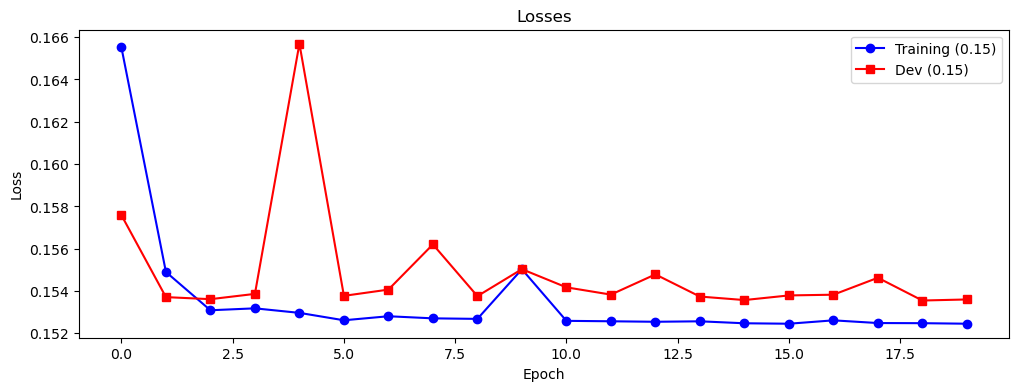

In [24]:
# loss plots
plt.figure(figsize=[12,4])

plt.plot(range(num_epochs), train_losses, "bo-")
plt.plot(range(num_epochs), test_losses, "rs-")
plt.title("Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend([f"Training ({train_losses[-1]:.2f})", f"Dev ({test_losses[-1]:.2f})"])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1566864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.297443].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9372549].
Clipping input data to 

torch.Size([256, 3, 32, 32])


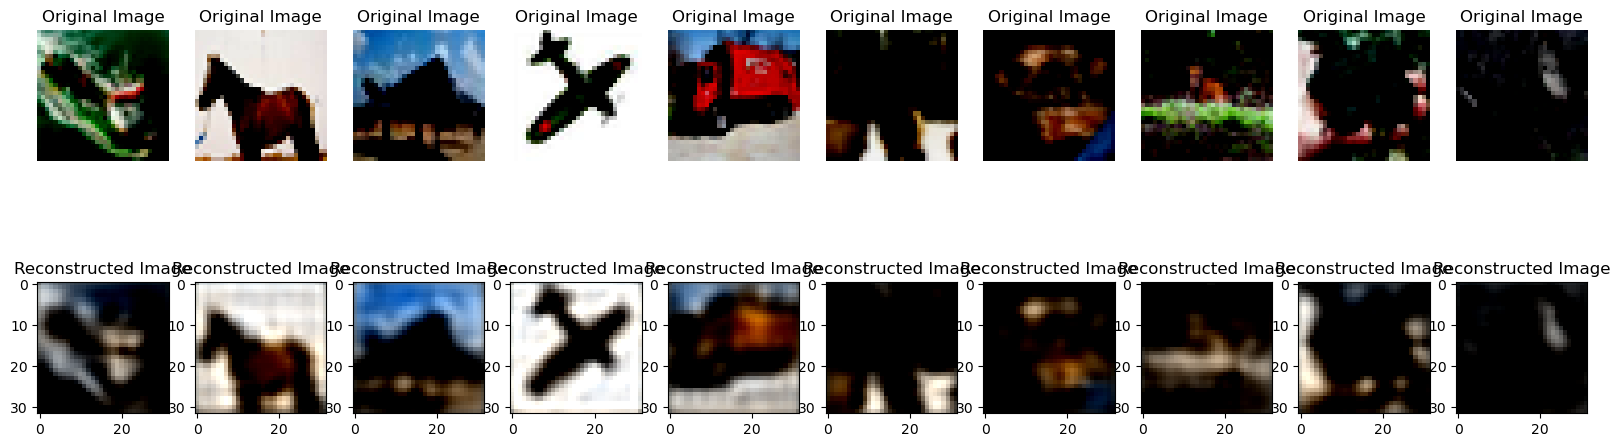

In [25]:
# test set outputs
fig, axs = plt.subplots(2,10, figsize=[20, 6])

# pull model to the cpu
model_cpu = model.cpu()
model.eval()

# choose 10 images to see
X_test, y_test = next(iter(test_loader))
print(X_test.shape)
img_indices = np.random.choice(X_test.shape[0],size=10)

# plot the encoding outputs
for i in range(10):
  og = X_test[img_indices[i],:,:,:].permute(1,2,0).detach()
  # revert normalization
  #og = og/2 + 0.5
  axs[0,i].imshow(og)
  axs[0,i].set_title("Original Image")
  axs[0,i].axis("off")

  output = model_cpu(X_test[img_indices[i],:,:,:]).permute(1,2,0).detach()
  # revert normalization
  #output = output / 2 + 0.5 
  axs[1,i].imshow(output, cmap=None)
  axs[1,i].set_title("Reconstructed Image")
  axs[0,i].axis("off")
